# CMB BBN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
from scipy.special import zeta
from astropy.cosmology import Planck18

## Neutron freeze-out

$$\Gamma_n \approx H$$
$$\Gamma_n = \sigma_w n_\nu c$$
$$n_\nu(T_\gamma) = \frac{3}{4}\frac{4}{11}n_\gamma(T_\gamma)\quad (only \nu_e)$$
$$n_\gamma = \frac{2 \zeta(3) (k_B T)^3}{\pi^2 \hbar^3 c^3}$$
$$\sigma_w = (G_F^2 E^2)/(\hbar c)^2 = G_F^2 (k_B T/(\hbar c))^2  = 5\times 10^{-48} \left(\frac{k_B T}{1\,\mathrm{MeV}}\right)^2\,\mathrm{m}^2 $$
$$G_F = 1.166 \times 10^{-5}\,\text{GeV}^{-2}$$
$$g_A = 1.26 \quad\text{(Kolb Turner p.91)}$$
$$ H = \sqrt{\frac{8 \pi^3 G}{90 \hbar^3 c^5}} g_\star^{1/2}(T) (k_B T)^2$$
$$g_\star(100\,\mathrm{MeV} > T > 511\,\mathrm{keV}) = 10.75$$
$$g_\star(T < 511\,\mathrm{keV}) = 3.36$$

In [2]:
T0 = 2.726 * u.K  # K
Qn = 1.29 * u.MeV
Neff = 3.046
gstar = 10.75  # at m_e < T < 100 MeV
gstar_after = 3.36  # at m_e > T
GF = 1.166e-5 / (u.GeV**2)
gA = 1.26
taun = 878.4 * u.s

In [3]:
def ng(T):
    return 2 * zeta(3) * (const.k_B * T)**3 / (np.pi**2 * const.hbar**3 * const.c**3)

ng(T0).to(1/u.cm**3)

<Quantity 410.95293609 1 / cm3>

In [4]:
# 3/4 for fermion nature, only 1 of the 3 flavors
# then 2 polarisations for photons vs g=2 for massless neutrinos
def nnu_e(T):
    return 4*ng(T)/11 * (3/4) #* Neff

nnu_e(T0).to(1/u.cm**3)

<Quantity 112.07807348 1 / cm3>

In [5]:
def H(T, gstar=gstar):
    return (np.sqrt(8*np.pi**3*const.G*gstar/(90*const.hbar**3*const.c**5))*(const.k_B * T)**2).to(1/u.s)

T_1MeV = (1 * u.MeV / const.k_B).to(u.K)
T_10MeV = (10 * u.MeV / const.k_B).to(u.K)
H(T_1MeV)  # OK with Kolb Turner formula p.91

<Quantity 0.67734578 1 / s>

In [6]:
def t_to_T(t, gstar=gstar):
    return (1/const.k_B*np.sqrt(1/(2*t)*np.sqrt(90*const.hbar**3*const.c**5/(8*np.pi**3*const.G*gstar) ))).to(u.K)

def T_to_t(T, gstar=gstar):
    return 1/(2*H(T, gstar=gstar))

t_to_T(10*u.s), T_to_t(t_to_T(10*u.s)), t_to_T(1*u.s)

(<Quantity 3.15287605e+09 K>, <Quantity 10. s>, <Quantity 9.97026951e+09 K>)

From equilibrium equations and rate with $G_G$ and $g_A$ :

In [7]:
sigma_np = (((GF**2)  * (1+3*gA**2)  * 1*u.MeV**2).to(1/u.GeV**2)* (const.hbar * const.c)**2).to(u.m**2)
sigma_np

<Quantity 3.05072871e-47 m2>

In [8]:
def Gamma_n(T):
    return (sigma_np * (const.k_B * T / (1*u.MeV))**2 * nnu_e(T) * const.c).to(1/u.s)

Gamma_n(T_1MeV)

<Quantity 0.07907673 1 / s>

In [9]:
from scipy.optimize import fsolve
Tfreeze = fsolve(lambda T: Gamma_n(T*u.K)-H(T*u.K), [1e8, 1e12])[1]
(Tfreeze*u.K * const.k_B).to(u.MeV)

<Quantity 2.04607038 MeV>

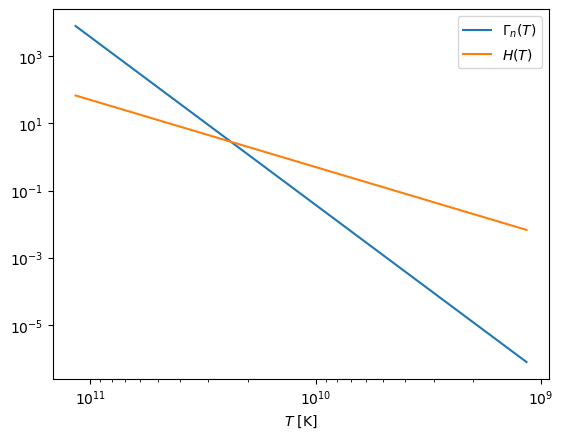

In [10]:
TT = (np.logspace(5, 7, 50) * u.eV/ const.k_B).to(u.K)

fig = plt.figure()
plt.plot(TT, Gamma_n(TT), label="$\Gamma_n(T)$")
plt.plot(TT, H(TT), label="$H(T)$")
plt.gca().invert_xaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("$T$ [K]")
plt.show()

Using Weinberg and Dodelson equations

Check equality of constant $g_V$ in Weinberg eq 15.7.9 p.547 with with Fermi constant $G_F$

In [11]:
gV = 1.418e-49*u.erg*u.cm**3
(gV/(const.hbar*const.c)**3).to(u.GeV**-2)

<Quantity 1.15187785e-05 1 / GeV2>

In [12]:
GF

<Quantity 1.166e-05 1 / GeV2>

In [13]:
A=(((gV/(const.hbar*const.c)**3)**2+3*(gA*gV/(const.hbar*const.c)**3)**2)/(2*np.pi**3)).to(u.GeV**-4)
A #*7/15*np.pi**4

<Quantity 1.23301053e-11 1 / GeV4>

In [14]:
A = GF**2*(1+3*gA**2)/(2*np.pi**3) * 1013/878
A

<Quantity 1.45769265e-11 1 / GeV4>

In [15]:
from scipy.integrate import quad
me = 511*u.keV

integrand_lpn = lambda q, T: (A*np.sqrt(1-(me/(Qn+q))**2)*(Qn+q)**2*(q)**2/(1+np.exp(-q/(const.k_B*T)))/(1+np.exp((Qn+q)/(const.k_B * T)))).to(u.dimensionless_unscaled)

integrand_lnp = lambda q, T: (A*np.sqrt(1-(me/(Qn+q))**2)*(Qn+q)**2*(q)**2/(1+np.exp(q/(const.k_B*T)))/(1+np.exp(-(Qn+q)/(const.k_B * T)))).to(u.dimensionless_unscaled)

def lnp(T):
    intp = quad(lambda q: integrand_lnp(q*u.MeV,T), (-Qn+me).to(u.MeV).value, np.inf)[0]
    intm = quad(lambda q: integrand_lnp(q*u.MeV,T), -np.inf, (-Qn-me).to(u.MeV).value)[0]
    return ((intp+intm)*u.MeV/const.hbar).to(1/u.s)

def lpn(T):
    intp = quad(lambda q: integrand_lpn(q*u.MeV,T), (-Qn+me).to(u.MeV).value, np.inf)[0]
    intm = quad(lambda q: integrand_lpn(q*u.MeV,T), -np.inf, (-Qn-me).to(u.MeV).value)[0]
    return ((intp+intm)*u.MeV/const.hbar).to(1/u.s)

def lambda_np_Bernstein(T):  # Dodeslon p.67
    x = Qn / (const.k_B * T)
    return (255/(taun*x**5)*(12+6*x+x**2)).to(1/u.s)

lnp(0.8*T_1MeV), lpn(0.8*T_1MeV) , H(0.8*T_1MeV)

(<Quantity 0.65549597 1 / s>,
 <Quantity 0.13069837 1 / s>,
 <Quantity 0.4335013 1 / s>)

Check that $\lambda_{pn} \sim \lambda_{np} e^{-Qn/T}$ :

In [16]:
lnp(0.8*T_1MeV) * np.exp(-Qn/(const.k_B * 0.8 * T_1MeV))

<Quantity 0.13069837 1 / s>

/Users/jneveu/miniforge3/envs/m2-cosmo/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


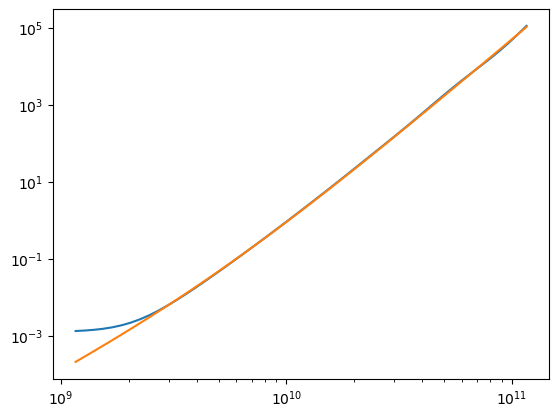

In [17]:
fig = plt.figure()
plt.plot(TT, np.array([lnp(T).value for T in TT])/u.s)
plt.plot(TT, lambda_np_Bernstein(TT))
plt.yscale("log")
plt.xscale("log")
plt.show()

Solve

In [18]:
from scipy.integrate import odeint

def dXndt_notaun(Xn, t):
    return (lambda_np_Bernstein(t_to_T(t*u.s))*( (1-Xn)*np.exp(-Qn/(const.k_B*t_to_T(t*u.s))) - Xn)).value

def dXndt(Xn, t):
    return (lambda_np_Bernstein(t_to_T(t*u.s))*( (1-Xn)*np.exp(-Qn/(const.k_B*t_to_T(t*u.s))) - Xn) - Xn/taun).value
    # return (lnp(t_to_T(t*u.s))*(-Xn + np.exp(-Qn/(const.k_B * t_to_T(t*u.s))) * (1-Xn))).value

tt = np.logspace(-3, 3, 100)

Xn_sol = odeint(dXndt, 1/(1+np.exp(Qn/(const.k_B * t_to_T(tt[0]*u.s)))), tt)
Xnt = lambda t: np.interp(t, tt*u.s, Xn_sol[:, 0])
XnT = lambda T: np.interp(T, t_to_T(tt[::-1]*u.s), Xn_sol[:, 0][::-1])

Xn_sol_notaun = odeint(dXndt_notaun, 1/(1+np.exp(Qn/(const.k_B * t_to_T(tt[0]*u.s)))), tt)
Xnt_notaun = lambda t: np.interp(t, tt*u.s, Xn_sol_notaun[:, 0])
XnT_notaun = lambda T: np.interp(T, t_to_T(tt[::-1]*u.s), Xn_sol_notaun[:, 0][::-1])

XnT(T_1MeV), Xnt(0.73*u.s)

(0.2551954566022299, 0.2560944672100634)

In [19]:
dXndt(XnT(1e10*u.K), T_to_t(1e10*u.K).value), XnT(1e10*u.K), H(1e10*u.K),1/(2*T_to_t(1e10*u.K)), T_to_t(1e10*u.K)

(-0.05939872803642697,
 0.23675385165897397,
 <Quantity 0.50298636 1 / s>,
 <Quantity 0.50298636 1 / s>,
 <Quantity 0.99406274 s>)

In [20]:
-dXndt(Xnt(1*u.s), 1), Xnt(1*u.s), H(t_to_T(1*u.s)), 1/(2*1*u.s), (const.k_B*t_to_T(1*u.s)).to(u.MeV)

(0.05915146300208578,
 0.23661759400216362,
 <Quantity 0.5 1 / s>,
 <Quantity 0.5 1 / s>,
 <Quantity 0.85917135 MeV>)

Differential equation 3.27 from Dodelson p.67

In [21]:
def dXndx(Xn, x):
    T = (Qn / (const.k_B * x)).to(u.K)
    return (x*lnp(T)/H(Qn/const.k_B)*(np.exp(-x) - Xn*(1+np.exp(-x)))).value

xx = np.logspace(-3, 3, 200)
XnDodelson_sol = odeint(dXndx, 1/(1+np.exp(xx[0])), xx)
XnDodelson_sol

array([[ 4.99750000e-01],
       [ 4.99732027e-01],
       [ 4.99712762e-01],
       [ 4.99692113e-01],
       [ 4.99669978e-01],
       [ 4.99646252e-01],
       [ 4.99620821e-01],
       [ 4.99593561e-01],
       [ 4.99564342e-01],
       [ 4.99533022e-01],
       [ 4.99499450e-01],
       [ 4.99463465e-01],
       [ 4.99424893e-01],
       [ 4.99383548e-01],
       [ 4.99339230e-01],
       [ 4.99291727e-01],
       [ 4.99240808e-01],
       [ 4.99186229e-01],
       [ 4.99127727e-01],
       [ 4.99065019e-01],
       [ 4.98997802e-01],
       [ 4.98925754e-01],
       [ 4.98848526e-01],
       [ 4.98765746e-01],
       [ 4.98677015e-01],
       [ 4.98581904e-01],
       [ 4.98479956e-01],
       [ 4.98370679e-01],
       [ 4.98253546e-01],
       [ 4.98127992e-01],
       [ 4.97993412e-01],
       [ 4.97849157e-01],
       [ 4.97694530e-01],
       [ 4.97528788e-01],
       [ 4.97351130e-01],
       [ 4.97160700e-01],
       [ 4.96956582e-01],
       [ 4.96737795e-01],
       [ 4.9

In [22]:
XnDodelson_sol[-1]

array([-3.83979787e-11])

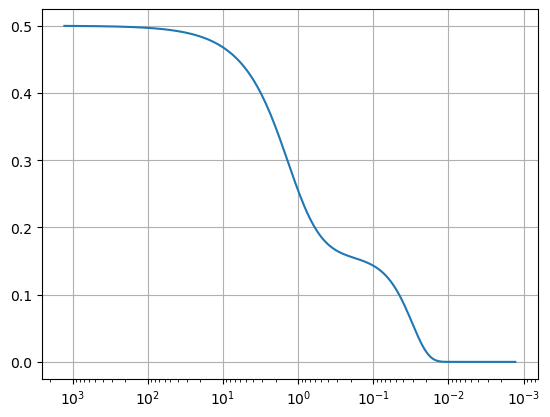

In [23]:
fig = plt.figure()
#plt.plot((TT*const.k_B).to(u.MeV), XnT(TT))
plt.plot((Qn / xx).to(u.MeV), XnDodelson_sol)
#plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid()
plt.show()

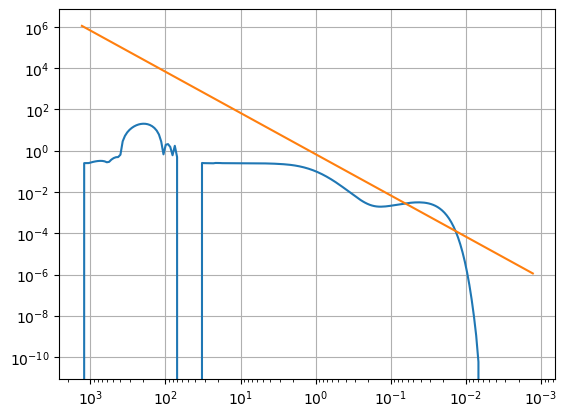

In [24]:


fig = plt.figure()
#plt.plot((TT*const.k_B).to(u.MeV), XnT(TT))
plt.plot((Qn / xx).to(u.MeV), [-dXndx(XnDodelson_sol[k], x) for k,x in enumerate(xx)])
plt.plot((Qn / xx).to(u.MeV), H((Qn / xx / const.k_B).to(u.K)), label="$H(T)$")
plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid()
plt.show()



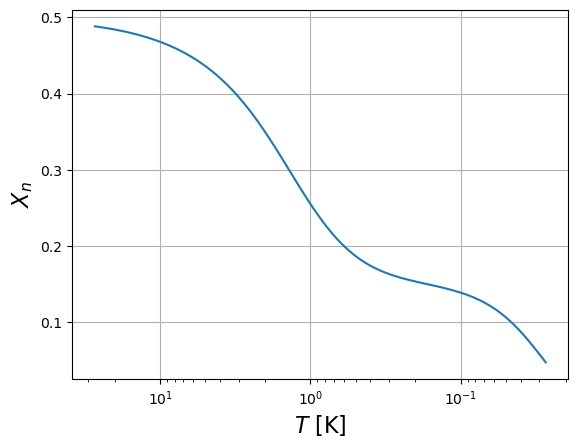

In [25]:
fig = plt.figure()
plt.plot((t_to_T(tt*u.s)*const.k_B).to(u.MeV), Xn_sol)
#plt.plot((t_to_T(tt*u.s)*const.k_B).to(u.MeV), XnDodelson_sol)
#plt.plot((Qn / xx).to(u.MeV), XnDodelson_sol)
#plt.plot((t_to_T(tt*u.s)*const.k_B).to(u.MeV), XnT(t_to_T(tt*u.s)))
#plt.plot((TT*const.k_B).to(u.MeV), XnT(TT))
#plt.plot((TT*const.k_B).to(u.MeV), Xnt(T_to_t(TT)))
#plt.plot((Qn / xx).to(u.MeV), Xn_sol)
#plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid()
plt.xlabel("$T$ [K]", fontsize=16)
plt.ylabel("$X_n$", fontsize=16)

plt.show()

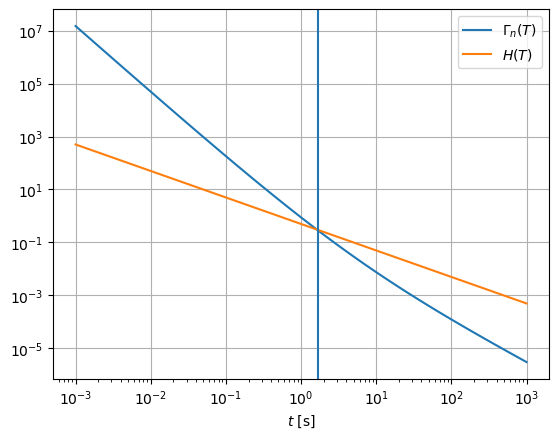

In [26]:
TTT = t_to_T(tt*u.s)

fig = plt.figure()
#plt.plot(tt, np.array([-dXndt(Xnt(t*u.s), t) for t in tt])/u.s, label="$\Gamma_n(T)$")
plt.plot(tt, lambda_np_Bernstein(TTT), label="$\Gamma_n(T)$")
#plt.plot(tt, np.array([lnp(T).value+lpn(T).value for T in TTT])/u.s, label="$\Gamma_n(T)$")
plt.plot(tt, 1/(2*tt), label="$H(T)$")
#plt.gca().invert_xaxis()
plt.axvline(1.7)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid()
plt.xlabel("$t$ [s]")
plt.show()

In [27]:
from scipy.optimize import fsolve
Tfreeze = fsolve(lambda T: lambda_np_Bernstein(T*u.K).value-H(T*u.K).value, [1e8, 1e12])[1] * u.K
(Tfreeze * const.k_B).to(u.MeV)

<Quantity 0.67481545 MeV>

In [28]:
def ratio_np(T):
    return XnT(T) / (1-XnT(T))

def ratio_np_notaun(T):
    return XnT_notaun(T) / (1-XnT_notaun(T))

npfreeze = ratio_np(Tfreeze)
npfreeze

0.26689641054394514

Proportion of neutrino converging after $T_{freeze}$:

In [29]:
npfreeze = ratio_np_notaun(1e7*u.K)

npfreeze

0.17357772462741972

## Deutérium ratio

In [31]:
BD = 2.22 * u.MeV
mn = 939.6 * u.MeV
Omegab0 = Planck18.Ob0
age = Planck18.lookback_time(np.inf)
rhoc0 = (3 * Planck18.H0**2 / (8 * np.pi * const.G) / const.m_p).to(1/u.m**3)

In [32]:
def nb(z):
    return Omegab0 * rhoc0 * (1+z)**3

eta = nb(0) / ng(T0)
eta

<Quantity 6.12602549e-10>

In [33]:
def ratio_Dn(T):
    # return (6*0.2*np.pi**3/2*eta*(const.k_B * T/(mn*const.c**2))**(3/2)*np.exp(BD/(const.k_B*T))).to(u.dimensionless_unscaled)
    return (6*(1-XnT(T))*2*zeta(3)*(np.pi/2)*eta*(const.k_B * T/mn)**(3/2)*np.exp(BD/(const.k_B*T))).to(u.dimensionless_unscaled)

ratio_Dn(Tfreeze)

<Quantity 5.65931387e-12>

In [34]:
from scipy.optimize import brentq
Tnuc = brentq(lambda T: ratio_Dn(T*u.K)-1, 1e8, 1e10) * u.K
Tnuc

<Quantity 7.92168258e+08 K>

In [35]:
(const.k_B * Tnuc).to(u.MeV)

<Quantity 0.06826378 MeV>

In [36]:
tnuc = T_to_t(Tnuc, gstar=gstar_after)
tnuc

<Quantity 283.34367157 s>

In [37]:
def ratio_np_after(T):
    return np.exp(-T_to_t(T, gstar=gstar_after)/taun)/(1/npfreeze + (1-np.exp(-T_to_t(T, gstar=gstar_after)/taun)))

npnuc = ratio_np_after(Tnuc)
npnuc

<Quantity 0.11997817>

In [38]:
T_to_t(0.1*u.MeV/const.k_B, gstar=gstar_after)

<Quantity 132.03654981 s>

In [39]:
npnuc = ratio_np(Tnuc)
npnuc

0.14268460673188912

Maximum helium 4 abondance (if all neutrons end in helium nuclei, no D nor Li nor...):

In [40]:
def Yp(np):
    return 2*np/(1+np)

Yp(npnuc)

0.24973576416675675

## Plots

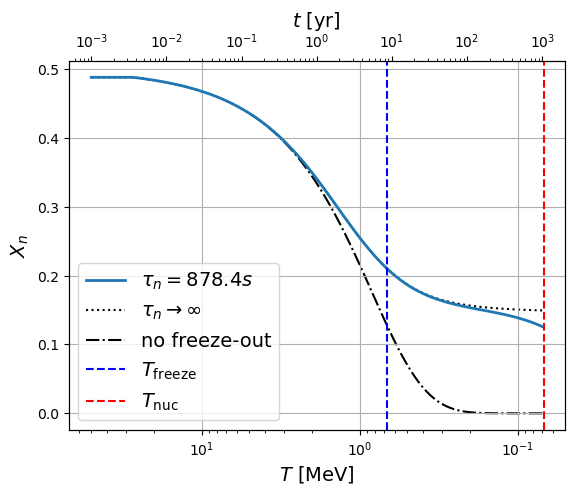

In [41]:
#| label: BBN_Xn

TT = (np.logspace(np.log10(7e4), np.log10(5e7), 100) * u.eV/ const.k_B).to(u.K)
TTafter = (np.logspace(np.log10(7e4), np.log10(5e6), 100) * u.eV/ const.k_B).to(u.K)
npeq = np.exp(-Qn/(const.k_B * TTafter))

fig = plt.figure()
plt.plot((TT*const.k_B).to(u.MeV), XnT(TT), label=rf"$\tau_n={taun:.1f}$", lw=2)
plt.plot((TT*const.k_B).to(u.MeV), XnT_notaun(TT), linestyle="dotted", label=r"$\tau_n \to \infty$", zorder=-2, color="k")
plt.plot((TTafter*const.k_B).to(u.MeV), npeq/(1+npeq), linestyle="-.", label=r"no freeze-out", zorder=-3, color="k")
#plt.yscale("log")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.xlabel("$T$ [MeV]", fontsize=14)
plt.ylabel("$X_n$", fontsize=14)
plt.axvline((Tfreeze * const.k_B).to(u.MeV).value, color="b", linestyle="--", label="$T_\mathrm{freeze}$")
plt.axvline((Tnuc * const.k_B).to(u.MeV).value, color="r", linestyle="--", label="$T_\mathrm{nuc}$")
plt.legend(fontsize=14)
plt.grid()

secax = plt.gca().twiny()
secax.plot(tt*u.s, Xnt(tt*u.s), linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [yr]', fontsize=14)

plt.show()

In [42]:
def ratio_mass_Dp(T):
    return 2*ratio_Dn(T)/(1+ratio_np(T))

def ratio_mass_Hp(T):
    if T > Tnuc:
        return 1/(1+ratio_np(T))
    else:
        return 1/(1+ratio_np(Tnuc))

def ratio_mass_Hep(T):
    if T > Tnuc:
        return 0
    else:
        return Yp(npnuc)

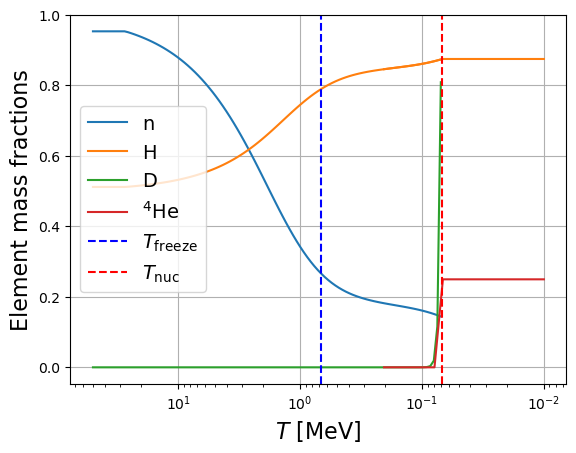

In [43]:
#| label: BBN_Yp

fig = plt.figure()
plt.plot((TT*const.k_B).to(u.MeV), ratio_np(TT), label="n")
p = plt.plot((TT*const.k_B).to(u.MeV), [ratio_mass_Hp(T) for T in TT], linestyle="-", label="H")
TTHe = (np.logspace(4, np.log10(3*(const.k_B * Tnuc).to(u.eV).value), 20) * u.eV/ const.k_B).to(u.K)
plt.plot((TTHe*const.k_B).to(u.MeV), [ratio_mass_Hp(T) for T in TTHe], linestyle="-", color=p[0].get_color())
plt.plot((TT*const.k_B).to(u.MeV), ratio_mass_Dp(TT), linestyle="-", label="D")
plt.plot((TTHe*const.k_B).to(u.MeV), [ratio_mass_Hep(T) for T in TTHe], linestyle="-", label="$^4$He")
plt.axvline((Tfreeze * const.k_B).to(u.MeV).value, color="b", linestyle="--", label="$T_\mathrm{freeze}$")
plt.axvline((Tnuc * const.k_B).to(u.MeV).value, color="r", linestyle="--", label="$T_\mathrm{nuc}$")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$T$ [MeV]", fontsize=16)
plt.ylabel("Element mass fractions", fontsize=16)
plt.gca().invert_xaxis()
#plt.ylim(1e-2, 1)
plt.grid()
plt.legend(fontsize=14, loc="center left")
plt.show()

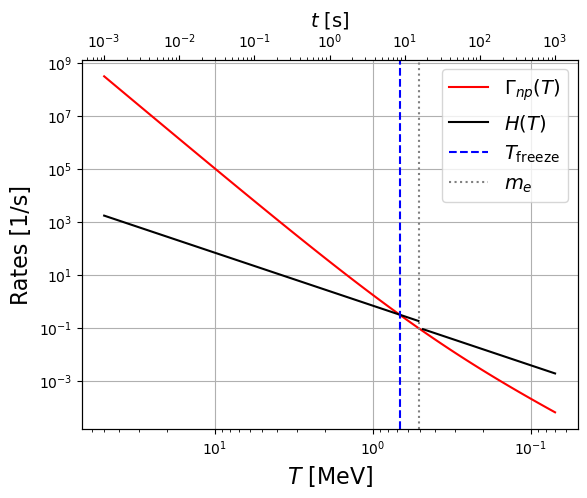

In [44]:
#| label: BBN_Gnp

E = (TT * const.k_B).to(u.MeV)
T_before_me = np.array([T.value for T in TT if (T * const.k_B > me)])*u.K
T_after_me = np.array([T.value for T in TT if (T * const.k_B <= me)])*u.K

fig = plt.figure()
#plt.plot(tt, np.array([-dXndt(Xnt(t*u.s), t) for t in tt])/u.s, label="$\Gamma_n(T)$")
plt.plot(E, lambda_np_Bernstein(TT), label="$\Gamma_{np}(T)$", color="r")
#plt.plot(E, np.array([lnp(T).value+lpn(T).value for T in TTT])/u.s, label="$\Gamma_n(T)$")
plt.plot((T_before_me * const.k_B).to(u.MeV), H(T_before_me, gstar=gstar), label="$H(T)$", color="k")
plt.plot((T_after_me * const.k_B).to(u.MeV), H(T_after_me, gstar=gstar_after), color="k")
plt.gca().invert_xaxis()
plt.axvline((Tfreeze * const.k_B).to(u.MeV).value, color="b", linestyle="--", label="$T_\mathrm{freeze}$")
plt.axvline(me.to(u.MeV).value, linestyle=":", label="$m_e$", color="gray")
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=14)
plt.grid()
plt.xlabel("$T$ [MeV]", fontsize=16)
plt.ylabel("Rates [1/s]", fontsize=16)

secax = plt.gca().twiny()
secax.plot(tt*u.s, H(t_to_T(tt*u.s, gstar=gstar), gstar=gstar), linestyle="none")
secax.plot(tt*u.s, H(t_to_T(tt*u.s, gstar=gstar_after), gstar=gstar_after), linestyle="none")
secax.set_xscale("log")
secax.set_xlabel('$t$ [s]', fontsize=14)

plt.show()

In [45]:
(13.6*u.eV / const.k_B).to(u.K)

<Quantity 157821.44645308 K>